<a href="https://colab.research.google.com/github/gjardim27/GuilhermeJardimPortfolio/blob/main/Gui_Process_PIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

replace 0 values in velocity arrays with nans

if that doesn't fix it, determine theta bounds

replace circle fit with curve_fit call

fix scale factor


In [1]:
# @title Setup

# Install packages with pip
# %pip install pint
%pip install pyfluids
# %pip install scipy
%pip install lvpyio==1.3.1


# @title Import dependencies
import gspread
import google.colab, google.auth
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.lines
import matplotlib
import numpy as np
import os
import pandas as pd
import lvpyio as lv
import pyfluids
import datetime
import time
import scipy
import yaml
import scipy.optimize
import scipy.interpolate

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


# Mount google drive (must be separate cell to avoid re-mounting errors)
# allows reading of text/.csv files from google drive, but NOT google sheets files.
force_remount = False # @param {type:"boolean"}
drive.mount('/content/drive', force_remount=force_remount)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.4 MB/s eta 0:00:00
Mounted at /content/drive


# PIV Perturbation Analysis

Scale is 0.019744 mm / box


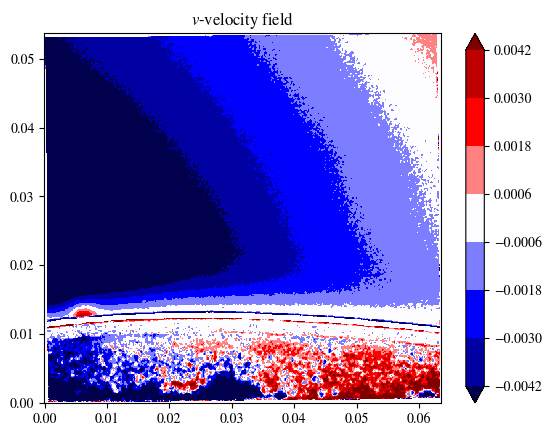

In [ ]:
# @title Load PIV

# Name of directory containing PIV data
piv_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/PIV/N65_WT_PIV_Flow_Fields"
mi_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/Model Installation/InstallationRunFolders"

# name of lavision project containing PIV data
project_run = 1387
project = f"CJK_NACA651412_RUN{project_run}"

project_path = os.path.join(piv_root, project)

# photo directory
photo_dir = os.path.join(mi_root, f"Run{project_run}")

c = 0.2

# Run number for processed PIV
run = 1414 # @param {type: "integer"}
#identify folder corresponding to run (regardless of TP number)
run_dir = next(f for f in os.listdir(project_path) if f.startswith(f"RUN{run}") and not f.endswith(".set"))

run_path = os.path.join(project_path, run_dir)

inst_piv_path = os.path.join(run_path, "PIV_MP(3x8x8_50%ov_ImgCorr)")
avgd_piv_path = os.path.join(inst_piv_path, "Avg_Stdev")
u_lim = 4.2e-3

piv_avg_b, piv_std_b = lv.read_set(avgd_piv_path)  # set has 2 buffers

scale = piv_avg_b[0].scales.x.slope
scale_unit = piv_avg_b[0].scales.x.unit
print(f"Scale is {scale} {scale_unit} / box")

piv_avg = piv_avg_b.as_masked_array()
mask = piv_avg.mask["u"][::-1,::-1]
u = piv_avg.data["u"][::-1,::-1]
v = piv_avg.data["v"][::-1,::-1]
# *scale converts to mm, *1000 to m, and /c to x/c
x = np.arange(u.shape[1])*scale/1000/c
y = np.arange(u.shape[0])*scale/1000/c
X, Y = np.meshgrid(x, y)

ticks = np.linspace(-u_lim, u_lim, 8, endpoint=True)
cmap = plt.colormaps['seismic']
norm = matplotlib.colors.BoundaryNorm(
    boundaries=ticks,
    ncolors=256,
    extend='both',
)

plt.pcolormesh(X, Y, v, cmap=cmap, norm=norm)
plt.colorbar(ticks=ticks)
plt.title('$v$-velocity field')

plt.show()


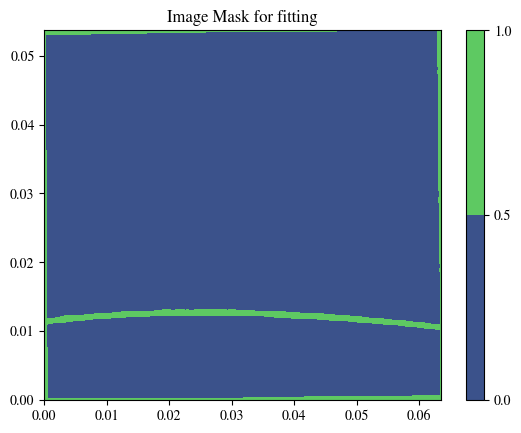

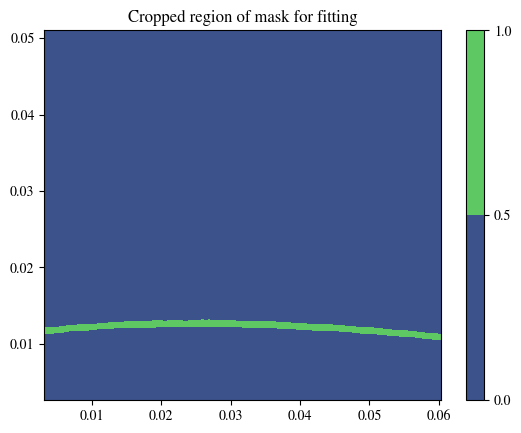

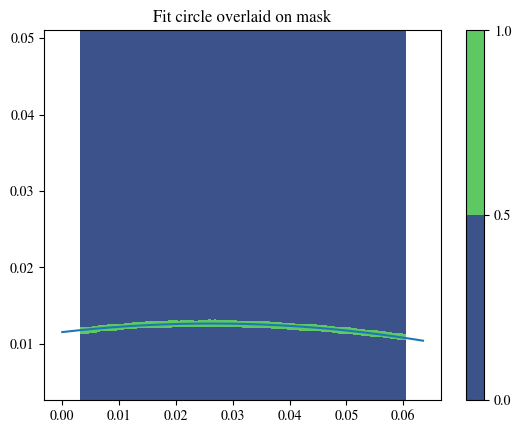

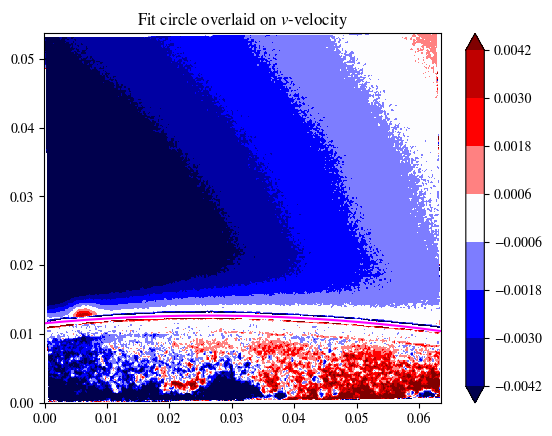

In [ ]:
# @title fit circle
plt.contourf(X, Y, mask)
plt.colorbar()
plt.title("Image Mask for fitting")
plt.show()

fit_region_prop = 0.9 # @param {type:"number"}
edge_prop = (1-fit_region_prop)/2
x_sz = len(x)
y_sz = len(y)
ix_min = int(edge_prop*x_sz)
iy_min = int(edge_prop*y_sz)
x_fit = x[ix_min:-ix_min]
y_fit = y[iy_min:-iy_min]
mask_fit = mask[iy_min:-iy_min,ix_min:-ix_min]
X_fit, Y_fit = np.meshgrid(x_fit, y_fit)

plt.contourf(X_fit, Y_fit, mask_fit)
plt.colorbar()
plt.title("Cropped region of mask for fitting")
plt.show()

def circle_to_fit(xc, yc, r, xp, yp, mask):
    """
    fit a circle to a set of points
    input arguments:
    xc: scalar x coordinate of center (to be fit)
    yc: scalar y coordinate of center (to be fit)
    r: scalar radius of circle (to be fit)
    xp: ndarray of x values of data points
    yp: ndarray of y values of data points
    """
    score = 0
    n, m = xp.shape
    for i in range(n):
        for j in range(m):
            x = xp[i,j]
            y = yp[i,j]
            if mask[i,j]:
                score += (np.sqrt((x-xc)**2 + (y-yc)**2) - r)**2
    score = np.sqrt(score)
    return score


minimization_function = lambda p: circle_to_fit(p[0], p[1], p[2], X_fit, Y_fit, mask_fit)
d_grid = np.sqrt((np.max(x)-np.min(x))**2 + (np.max(y)-np.min(y))**2)  # diameter (diagonal) of image
p0 = (0, 0, d_grid)
res = scipy.optimize.minimize(minimization_function, p0).x
xc, yc, r = res
circle = lambda x: yc + np.sqrt(r**2 - (x-xc)**2)

plt.plot(x, circle(x))
plt.contourf(X_fit, Y_fit, mask_fit)
plt.colorbar()
plt.title("Fit circle overlaid on mask")
plt.show()

plt.plot(x, circle(x), c='magenta')
plt.pcolormesh(X, Y, v, cmap=cmap, norm=norm)
plt.colorbar(ticks=ticks)
plt.title("Fit circle overlaid on $v$-velocity")
plt.show()




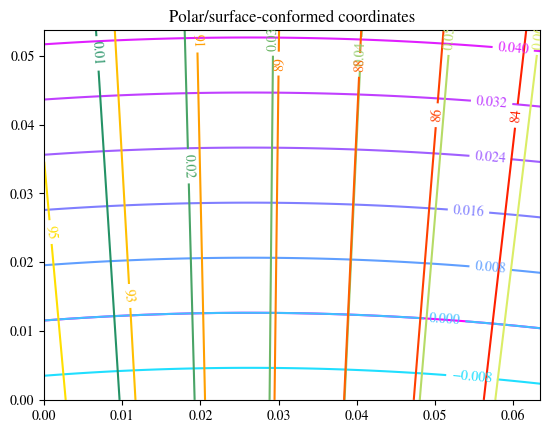

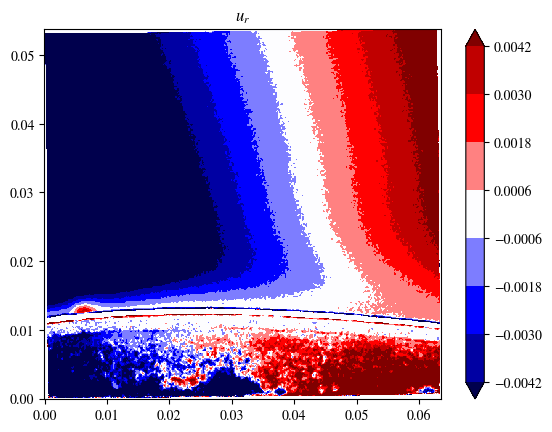

In [ ]:
# @title Convert to surface-conformed coordinates
X_shifted = X - xc
Y_shifted = Y - yc

rho = np.sqrt(X_shifted**2 + Y_shifted**2) - r
theta = np.arctan2(Y_shifted, X_shifted)

theta2xi = lambda phi:  r*(np.max(theta) - phi)
xi2theta = lambda xi: np.max(theta) - xi/r

xi = theta2xi(theta)

ur = (u*X_shifted+v*Y_shifted)/(rho+r)

plt.plot(x, circle(x), c='magenta')

rho_cs = plt.contour(X, Y, rho, cmap="cool")
plt.clabel(rho_cs, rho_cs.levels)

xi_cs = plt.contour(X, Y, xi, cmap="summer")
plt.clabel(xi_cs, xi_cs.levels)

theta_cs = plt.contour(X, Y, theta, cmap="autumn")
plt.clabel(theta_cs, theta_cs.levels, fmt=lambda phi: f"{np.rad2deg(phi):0.0f}")

plt.title("Polar/surface-conformed coordinates")
plt.show()

plt.title("$u_r$")
urc = plt.pcolormesh(X, Y, ur, cmap=cmap, norm=norm)
plt.colorbar(urc, ticks=ticks)
plt.show()



a: 3.93e-03, xbar: 6.37e-03, sigma: 1.17e-03
a: 2.27e-03, xbar: 6.41e-03, sigma: 1.55e-03
a: 1.50e-03, xbar: 6.45e-03, sigma: 1.84e-03
a: 9.39e-04, xbar: 6.50e-03, sigma: 2.18e-03
a: 4.49e-04, xbar: 7.32e-03, sigma: 1.97e-03


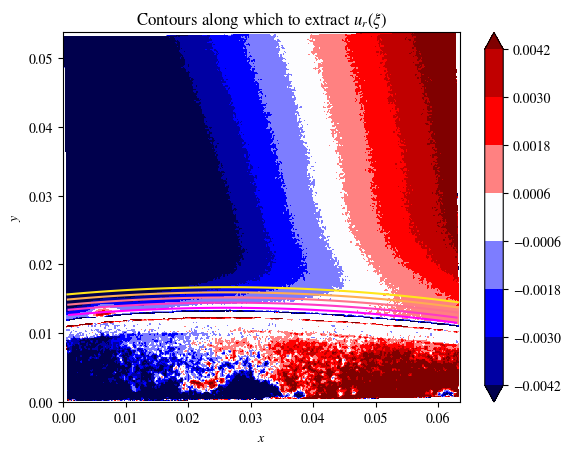

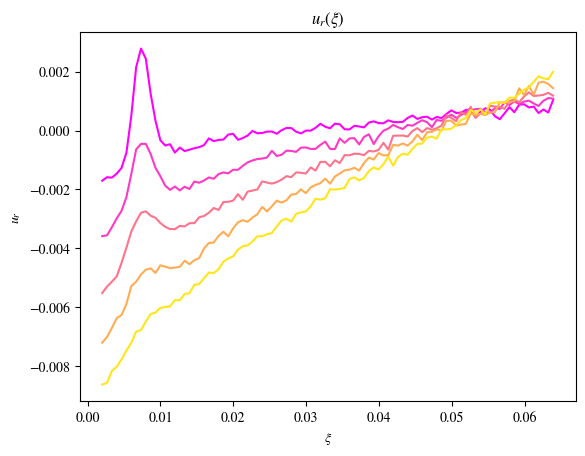

In [ ]:
# @title Plot $u_r(\xi)$ for various $\eta$

# define ur for interpolation
ur_cmap = matplotlib.colormaps['spring']
ur_interp = scipy.interpolate.RegularGridInterpolator((x, y), ur.T, fill_value=np.nan, bounds_error=False)

maxtheta = xi2theta(np.min(xi))
theta_arr = np.linspace(np.min(theta), maxtheta, 100)
# theta_arr = theta_arr[3:-4]
theta_deg_arr = np.rad2deg(theta_arr)
etavalues = np.linspace(10e-4, 40e-4, 5)

def color(eta):
    # put eta between 0 and 1
    eta_scaled = (eta-np.min(etavalues))/(np.max(etavalues)-np.min(etavalues))
    # remove last 10% which is too yellow
    eta_scaled = eta_scaled*0.9
    return ur_cmap(eta_scaled)

xwid_fig_ur_xi = 0.03

# fit Gaussian of amplitude a, mean mu, and std sigma summed with 2nd order polynomial
ur_curve = lambda x, a, mu, sigma, b, m, q, c: a*np.exp(-(x-mu)**2/(2*sigma**2)) + b + m*x + q*x**2 + c*x**3

plt.figure(2)
plt.title(r"$u_r(\xi)$")
plt.xlabel(r"$\xi$")
plt.ylabel("$u_r$")
# plt.xlim(0, xwid_fig_ur_xi)

plt.figure(1)
plt.pcolormesh(X, Y, ur, cmap=cmap, norm=norm)
plt.colorbar(ticks=ticks)
plt.title(r"Contours along which to extract $u_r(\xi)$")
y_0fig_ur_xi = 0.005
# plt.xlim(0, xwid_fig_ur_xi)
# plt.ylim(y_0fig_ur_xi, y_0fig_ur_xi+xwid_fig_ur_xi)
plt.xlabel("$x$")
plt.ylabel("$y$")
for eta in etavalues:
    r_eta = eta + r

    x_arr, y_arr = r_eta*np.cos(theta_arr)+xc, r_eta*np.sin(theta_arr)+yc
    xi_arr = theta2xi(theta_arr)
    ur_arr = ur_interp((x_arr, y_arr))

    # remove nans aand 0s from arrays
    good_indices = np.logical_and(np.logical_not(np.isnan(ur_arr)), ur_arr != 0)
    x_arr = x_arr[good_indices]
    y_arr = y_arr[good_indices]
    xi_arr = xi_arr[good_indices]
    ur_arr = ur_arr[good_indices]

    urpopt, urpcov = scipy.optimize.curve_fit(ur_curve, x_arr[1:-2], ur_arr[1:-2], (0.006, 0.007, 0.001, -0.004, 0.11, -0.5, 0))
    a_fit, mu_fit, sigma_fit, b_fit, m_fit, q_fit, c_fit = urpopt
    if mu_fit < np.min(x_arr):
        a_fit = 0
        sigma_fit = np.nan
        xbar = np.nan
    ur_curve_fit = lambda x: ur_curve(x, a_fit, mu_fit, sigma_fit, b_fit, m_fit, q_fit, c_fit)

    plt.figure(1)  # contours overlaid on ur
    plt.plot(x_arr, y_arr, "-", c=color(eta))

    plt.figure(2)  # ur(xi)
    plt.plot(xi_arr, ur_arr, "-", c=color(eta))
    # plt.plot(xi_arr, ur_curve_fit(x_arr), '--', c=color(eta))
    print(f'a: {a_fit:1.2e}, xbar: {mu_fit:1.2e}, sigma: {sigma_fit:1.2e}')


plt.show()


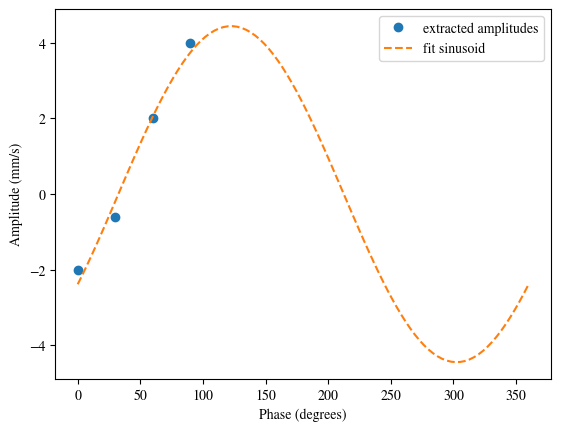

4.44e+00


In [ ]:
phase_scr = np.linspace(90, 0, 4)
amps_scr = np.array([4, 2, -0.6, -2])  # 240 Hz
# amps_scr = np.array([0.6, 0.9, 1, 1])  # 30  Hz


plotting_phases = np.linspace(0, 360, 100)

sin_fit_params = lambda x, a_sin, phi_sin: a_sin*np.sin(2*np.pi*x/360+phi_sin)

sin_popt = scipy.optimize.curve_fit(sin_fit_params, phase_scr, amps_scr)
a_sin_fit, phi_sin_fit = sin_popt[0]

sin_fit = lambda x: sin_fit_params(x, a_sin_fit, phi_sin_fit)

plt.plot(phase_scr, amps_scr, 'o', label="extracted amplitudes")
plt.plot(plotting_phases, sin_fit(plotting_phases), "--", label="fit sinusoid")
plt.xlabel("Phase (degrees)")
plt.ylabel("Amplitude (mm/s)")
plt.legend()
plt.show()

print(f"{a_sin_fit:1.2e}")

Files in run_path:
PIV_MP(3x16x16_50%ov_ImgCorr).set
PIV_MP(3x16x16_50%ov_ImgCorr)
RUN1178TP1.pkl
Scale: 0.0997142 mm/box


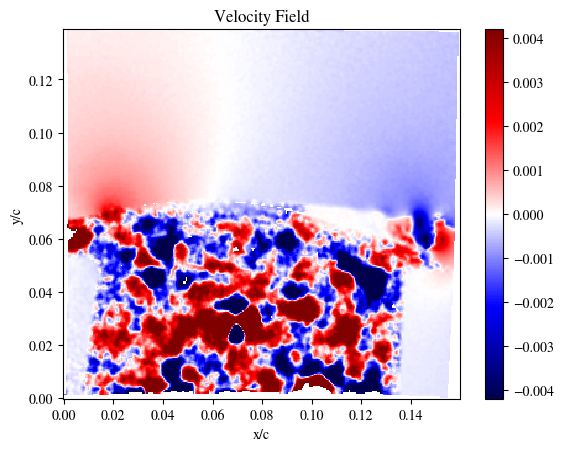

[[         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 ...
 [         nan          nan          nan ...   0.2384611  -14.75197384
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]]


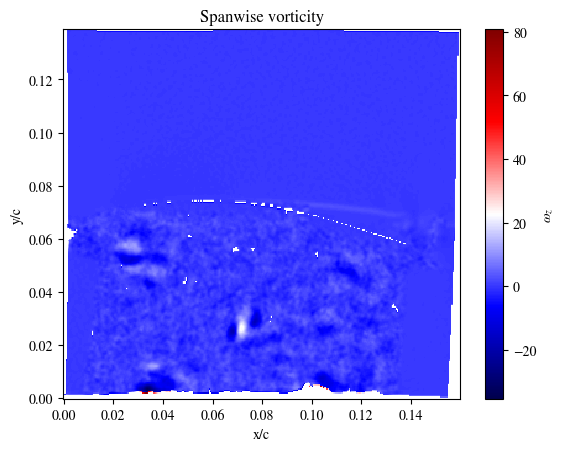

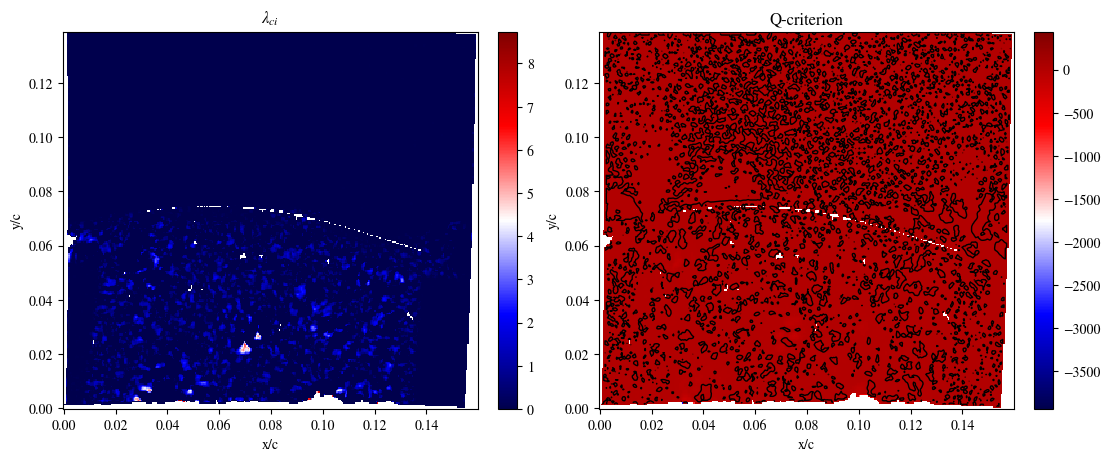

In [6]:
# @title Vorticity Identification from Instanteneous PIV

# Name of directory containing PIV data
piv_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/PIV/N65_WT_PIV_Flow_Fields"
mi_root = r"/content/drive/MyDrive/Wind Tunnel Shared/Experimental Campaigns/24-01_Naca_651412_Campaign/Model Installation/InstallationRunFolders"

# Name of LaVision project containing PIV data
project_run = 1117
project = f"CJK_NACA651412_RUN{project_run}" # Folder name

project_path = os.path.join(piv_root, project)

# Photo directory
photo_dir = os.path.join(mi_root, f"Run{project_run}")

c = 0.2
# Run number
run = 1178 # @param {type: "integer"}
#identify folder corresponding to run (regardless of TP number)
run_dir = next(f for f in os.listdir(project_path) if f.startswith(f"RUN{run}") and not f.endswith(".set"))

run_path = os.path.join(project_path, run_dir)

# List files in the run_path to find the correct PIV folder name
print("Files in run_path:")
for f in os.listdir(run_path):
    print(f)

# Load Data
inst_piv_path = os.path.join(run_path, "PIV_MP(3x16x16_50%ov_ImgCorr)")
u_lim = 4.2e-3 # Velocity Limits

# Load the LaVision SET containing instantaneous PIV frames
buffer = lv.read_set(inst_piv_path)
frames = buffer[0]

# Create Mask and take scale and unit from LaVision Set
piv = frames[0].as_masked_array()
scale = frames[0].scales.x.slope
unit  = frames[0].scales.x.unit
print(f"Scale: {scale} {unit}/box")

# Extract U and V velocity components
mask = piv.mask["u"][::-1, ::-1]
U = piv.data["u"][::-1, ::-1]
V = piv.data["v"][::-1, ::-1]
U = U / 1000
V = V / 1000
U = U.astype(float)
V = V.astype(float)

U[mask] = np.nan
V[mask] = np.nan

# Build Grid
x = np.arange(U.shape[1])*scale/1000/c
y = np.arange(U.shape[0])*scale/1000/c
X, Y = np.meshgrid(x, y)

# quick plot to verify orientation/values
u_lim = 4.2e-3
plt.figure()
plt.pcolormesh(X, Y, V, cmap='seismic', vmin=-u_lim, vmax=u_lim, shading='nearest')
plt.colorbar(); plt.title('Velocity Field'); plt.xlabel('x/c'); plt.ylabel('y/c')
plt.show()

def safe_gradient(F, dx, dy, mask):
    F_filled = F.copy()
    F_filled[mask] = 0.0

    dF_dy, dF_dx = np.gradient(F_filled, dy, dx)

    dF_dx[mask] = np.nan
    dF_dy[mask] = np.nan
    return dF_dy, dF_dx

#Define Important Flow Equations
def gradients(U, V, X, Y, mask):
  dx = np.median(np.diff(X[0,:]))
  dy = np.median(np.diff(Y[:,0]))
  dU_dy, dU_dx = safe_gradient(U, dx, dy, mask)
  dV_dy, dV_dx = safe_gradient(V, dx, dy, mask)
  dU_dx[mask] = np.nan
  dU_dy[mask] = np.nan
  dV_dx[mask] = np.nan
  dV_dy[mask] = np.nan
  tr = dU_dy + dV_dx
  det = dU_dy * dV_dx - dU_dx * dV_dy
  disc = tr**2 - 4.0*det
  return dx, dy, dU_dy, dU_dx, dV_dy, dV_dx, tr, det, disc

dx, dy, dU_dy, dU_dx, dV_dy, dV_dx, tr, det, disc = gradients(U, V, X, Y, mask)


def swirling_strength(dU, dV, disc, mask):
  lamci = np.zeros_like(dU)
  m = disc < 0.0
  lamci = np.zeros_like(dU)
  lamci[m] = 0.5*np.sqrt(-disc[m])
  lamci[mask] = np.nan
  return lamci

lamci = swirling_strength(dU_dx, dV_dy, disc, mask)
# Q-Criterion
def q_criterion(dU_dx, dU_dy, dV_dx, dV_dy, mask):
    # Strain-rate tensor
    sxx = dU_dx
    syy = dV_dy
    sxy = 0.5 * (dU_dy + dV_dx)

    # Rotation (out-of-plane vorticity)
    omega_z = dV_dx - dU_dy

    S2 = sxx**2 + syy**2 + 2.0 * sxy**2
    Omega2 = 0.5 * omega_z**2

    Q = 0.5 * (Omega2 - S2)
    Q[mask] = np.nan
    return Q

Q = q_criterion(dU_dx, dU_dy, dV_dx, dV_dy, mask)
print(Q)
omega_z = dV_dx - dU_dy

plt.figure()
plt.pcolormesh(X, Y, omega_z, shading='nearest', cmap='seismic')
plt.colorbar(label=r'$\omega_z$')
plt.title('Spanwise vorticity')
plt.xlabel('x/c'); plt.ylabel('y/c')
plt.show()
omega_z = dV_dx - dU_dy

omega_z = dV_dx - dU_dy

fig, ax = plt.subplots(1,2, figsize=(11,4.5), constrained_layout=True)

im0 = ax[0].pcolormesh(X, Y, lamci, shading='nearest', cmap='seismic')
ax[0].set_title(r'$\lambda_{ci}$'); ax[0].set_xlabel('x/c'); ax[0].set_ylabel('y/c')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].pcolormesh(X, Y, Q, shading='nearest', cmap='seismic')
ax[1].contour(X, Y, Q, levels=[0.0], colors='k', linewidths=1.0)  # Q=0 boundary
ax[1].set_title('Q-criterion'); ax[1].set_xlabel('x/c'); ax[1].set_ylabel('y/c')
fig.colorbar(im1, ax=ax[1])

plt.show()


